In [7]:
import torch
from torch import nn
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

class MisogynyCls(nn.Module):
    def __init__(self, num_linear_layers, task_a_out=1, task_b_out=4, input_dim=1024, hidden_dim=512, drop_value=0.2):
        super().__init__()
        self.head_task_a = nn.Linear(hidden_dim, task_a_out)
        self.head_task_b = nn.Linear(hidden_dim, task_b_out)
        self.sigmoid = nn.Sigmoid()
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Check if CUDA is available
        
        # Pretrained CLIP loading...
        self.clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        self.clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


        self.layers = nn.ModuleList()

        for i in range(num_linear_layers):
            if i == 0:
                self.layers.append(nn.Linear(input_dim, hidden_dim))
            else:
                self.layers.append(nn.Linear(hidden_dim, hidden_dim))
                
            self.layers.append(nn.BatchNorm1d(hidden_dim))
            self.layers.append(nn.Dropout(drop_value))
            self.layers.append(nn.ReLU())


    def forward(self, text_list, image_list):
        clip_inputs = self.clip_processor(text=text_list, images=image_list, return_tensors="pt", padding=True, truncation=True)
        clip_outputs = self.clip_model(**clip_inputs)
        
        x = torch.cat([clip_outputs['text_embeds'], clip_outputs['image_embeds']], dim=1).to(self.device) # model input is the concatenation of the two modalities !
        
        for layer in self.layers:
            x = layer(x)
            #print(x.shape)
        pred_taskA = self.sigmoid(self.head_task_a(x))
        pred_taskB = self.sigmoid(self.head_task_b(x))
        
        return pred_taskA, pred_taskB

In [8]:
import shap
import torch
import numpy as np
from PIL import Image
import os, copy, sys
import math, json
import random
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from nltk.tokenize import word_tokenize


class MMSHAP:
    
    def __init__(self,
                 classifier):
        self.classifier = classifier
        self.img = None
        self.txt = None
        self.num_txt_token = None
        self.patch_size = None
        
    def display_image_text(self, shap_values):
        print(f'shap_values.shape: {shap_values.shape}')
        
        # here the actual masking of the image is happening. The custom masker only specified which patches to mask, but no actual masking has happened
        shap_values_txt = shap_values.values[0, :self.num_txt_token]
        shap_values_patches = shap_values.values[0, self.num_txt_token:]
        shap_values_img = torch.zeros(self.img.shape) # DA RIEMPIRE CON GLI SHAPLEY VALUE CALCOLATI SULLE PATCH
        data_txt = shap_values.data[0, :self.num_txt_token]
        
        print(f'shap_values_txt.shape: {shap_values_txt.shape}')
        print(f'shap_values_patches.shape: {shap_values_patches.shape}')
        print(f'shap_values_img.shape: {shap_values_img.shape}')
        print(f'self.image.shape: {self.img.shape}')
        print(f'patch_size: {self.patch_size}')
        
        row_cols = 224 // self.patch_size # 224 / 32 = 7

        # PATCHIFY THE IMAGE & SET THE PATCH TO THE RIGHT SHAPLEY VALUE (THIS MATRIX WILL THEN BE PASSED TO THE IMAGE_PLOT FUNCTION IN SHAP)
        for (i, shap_val) in enumerate(shap_values_patches):
            print(f'i: {i} - shap_val: {shap_val}')
            m = i // row_cols
            n = i % row_cols
            shap_values_img[:, m*self.patch_size:(m+1)*self.patch_size, n*self.patch_size:(n+1)*self.patch_size] = shap_val # torch.rand(3, patch_size, patch_size)  # np.random.rand()
        
        # plot shapley values for texts and images
        
        print(f"shap_values_img.unsqueeze(3): {shap_values_img.unsqueeze(3).shape}")
        
        shap.image_plot(
            shap_values=shap_values_img.unsqueeze(3), 
            pixel_values=self.img.numpy(),
        )
        
        #shap.plots.text(txt_shap_val[0], display=False)
        
        # fai qui quello del testo
        
        
    def custom_masker(self, mask, x):
        masked_X = np.copy(x).reshape(1, -1) # fai controllo per vedere se effettivamente ha una shape  e.g. (1, 15)
        mask = np.expand_dims(mask, axis=0) # same as unsqueeze(0)
        masked_X[~mask] = "UNK"
        return masked_X

    def get_model_prediction(self, x): # x must be an ndarray of strings representing the couple (perturbed_txt, perturbed_img)
        #print(x)
        self.classifier.eval()
        perturbed_imgs = []

        with torch.no_grad():
            # split up the input_ids and the image_token_ids from x (containing both appended)
            masked_txt_tokens = [input_string[:self.num_txt_token] for input_string in x]
            masked_image_tokens = [input_string[self.num_txt_token:] for input_string in x]
            perturbed_txts = [' '.join(token_list.tolist()) for token_list in masked_txt_tokens]
            
            #print(perturbed_txts)

            result = np.zeros(len(x))
            row_cols = 224 // self.patch_size # 224 / 32 = 7

            # call the model for each "new image" generated with masked features
            for i in range(len(x)):
                perturbed_img = copy.deepcopy(self.img)

                # here the actual masking of the image is happening. The custom masker only specified which patches to mask, but no actual masking has happened
                curr_masked_txt_tokens = copy.deepcopy(masked_txt_tokens[i])

                # PATCHIFY THE IMAGE
                for k in range(len(masked_image_tokens[i])):
                    if masked_image_tokens[i][k] == "UNK":  # should be the patch we want to mask
                        m = k // row_cols
                        n = k % row_cols
                        perturbed_img[:, m*self.patch_size:(m+1)*self.patch_size, n*self.patch_size:(n+1)*self.patch_size] = 0 # torch.rand(3, patch_size, patch_size)  # np.random.rand()

                perturbed_imgs.append(perturbed_img)

            outputs_taskA, _ = self.classifier(perturbed_txts, perturbed_imgs)

        return outputs_taskA

    
    def compute_mmscore(self, num_txt_tokens, shap_values):
        print(shap_values.values.shape)
        #print(shap_values.data)
        
        text_contrib = np.abs(shap_values.values[0, :num_txt_tokens]).sum()
        image_contrib = np.abs(shap_values.values[0, num_txt_tokens:]).sum()
        text_score = text_contrib / (text_contrib + image_contrib)
        image_score = image_contrib / (text_contrib + image_contrib) # is just 1 - text_score in the two modalities case
        return text_score, image_score
    
    def wrapper_mmscore(self, txt_to_explain, img_to_explain): # specify better the types of the parameters (img must be a tensor of shape CxWxH)
        mmscore_list = []
        
        for txt, img in zip(txt_to_explain, img_to_explain):
            
            txt_tokens = word_tokenize(txt)
            num_txt_tokens = len(txt_tokens)
            p = int(math.ceil(np.sqrt(num_txt_tokens)))
            patch_size = 224 // p
            img_tokens = [" " for el in range(1, p**2+1)]
            txt_tokens = np.array(txt_tokens + img_tokens)

            self.img = img
            self.txt = txt
            self.num_txt_token = num_txt_tokens
            self.patch_size = patch_size

            explainer = shap.Explainer(self.get_model_prediction, self.custom_masker, silent=True)

            # print(txt_tokens.shape)
            # print(type(txt_tokens))
            txt_tokens = txt_tokens.reshape(1, -1)
            #print(txt_tokens)

            shap_values = explainer(txt_tokens)
            self.display_image_text(shap_values)
                        
            print(self.num_txt_token)
            print(shap_values.values.shape)
            print(shap_values.values[0, self.num_txt_token:])

            text_score, image_score = self.compute_mmscore(num_txt_tokens, shap_values)
            mmscore_list.append(text_score)
            
        mmscore_array = np.array(mmscore_list)
        mmshap_mean = np.mean(mmscore_array)
        mmshap_variance = np.var(mmscore_array)
        
        return mmshap_mean, mmshap_variance # image_score si ricava in automatico da text_score

The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).


shap_values.shape: (1, 26)
shap_values_txt.shape: (10,)
shap_values_patches.shape: (16,)
shap_values_img.shape: torch.Size([3, 224, 224])
self.image.shape: torch.Size([3, 224, 224])
patch_size: 56
i: 0 - shap_val: 7.44023256831699e-07
i: 1 - shap_val: -4.840290380848778e-07
i: 2 - shap_val: -7.742136302921507e-07
i: 3 - shap_val: 9.269505325290892e-07
i: 4 - shap_val: 6.697761515776316e-07
i: 5 - shap_val: 3.741847144232856e-07
i: 6 - shap_val: -7.2744054098924e-07
i: 7 - shap_val: -1.0223852263556586e-07
i: 8 - shap_val: 1.4006574120786454e-06
i: 9 - shap_val: 1.5233332912127178e-06
i: 10 - shap_val: 8.476070231861538e-07
i: 11 - shap_val: 1.001326988140742e-06
i: 12 - shap_val: 1.5376394407616722e-06
i: 13 - shap_val: 9.31995196474923e-07
i: 14 - shap_val: 4.4907857146528033e-07
i: 15 - shap_val: 4.4889748096466064e-07
shap_values_img.unsqueeze(3): torch.Size([3, 224, 224, 1])


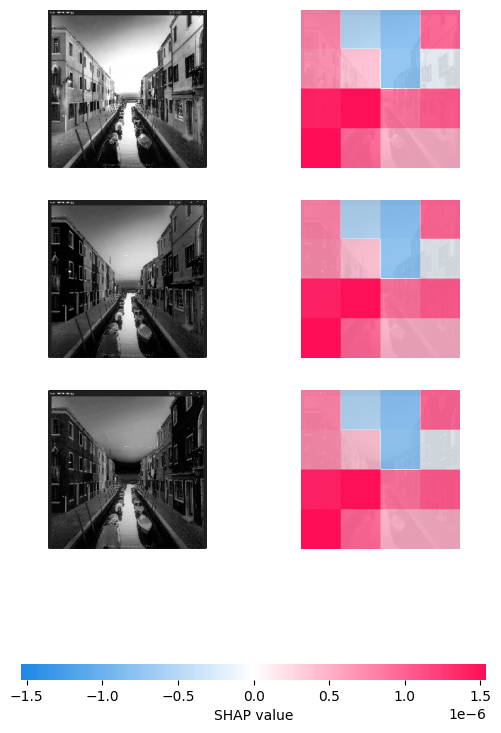

10
(1, 26)
[ 7.44023257e-07 -4.84029038e-07 -7.74213630e-07  9.26950533e-07
  6.69776152e-07  3.74184714e-07 -7.27440541e-07 -1.02238523e-07
  1.40065741e-06  1.52333329e-06  8.47607023e-07  1.00132699e-06
  1.53763944e-06  9.31995196e-07  4.49078571e-07  4.48897481e-07]
(1, 26)


In [9]:
from torchvision import transforms

checkpoint = torch.load('/kaggle/input/model-params/model_3.pth', map_location=torch.device('cpu'))
classifier = MisogynyCls(5)
classifier.load_state_dict(checkpoint)

mmshap_analyzer = MMSHAP(classifier)
resize = transforms.Resize((224, 224))
#txt = ["mi chiamo silvio e sono bellissimo", "miao miao miao", "yo yo yu ghdhd "]
#image = [transforms.ToTensor()(Image.new('RGB', (224, 224), color='white')) for i in range(3)] # DA FARE UN RESIZE DI (224, 224)

txt = ["mi chiamo silvio e sono molto bello mannaggia alla Madonna"]
image = [resize(transforms.ToTensor()(Image.open("/kaggle/input/build-exmaple/build.jpg")))]
#image = [transforms.ToTensor()(Image.new('RGB', (224, 224), color='white'))] # DA FARE UN RESIZE DI (224, 224)

#text_score_mean, test_score_variance = mmshap_analyzer.wrapper_mmscore(txt, image)
txt_score_mean, txt_score_variance = mmshap_analyzer.wrapper_mmscore(txt, image)
